In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import umap
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier


In [25]:
# Ladda datasetet
column_names = ["ID", "Diagnosis", "Radius_mean", "Texture_mean", "Perimeter_mean", "Area_mean", 
                "Smoothness_mean", "Compactness_mean", "Concavity_mean", "Concave_points_mean", 
                "Symmetry_mean", "Fractal_dimension_mean", "Radius_se", "Texture_se", "Perimeter_se", 
                "Area_se", "Smoothness_se", "Compactness_se", "Concavity_se", "Concave_points_se", 
                "Symmetry_se", "Fractal_dimension_se", "Radius_worst", "Texture_worst", 
                "Perimeter_worst", "Area_worst", "Smoothness_worst", "Compactness_worst", 
                "Concavity_worst", "Concave_points_worst", "Symmetry_worst", "Fractal_dimension_worst"]

data = pd.read_csv('wdbc.data', header=None, names=column_names)

# Ta bort ID-kolumnen och omvandla "Diagnosis" till numeriska värden
data = data.drop(columns=["ID"])
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Visa de första raderna av datasetet
print(data.head())

# Kontrollera för saknade värden
print(data.isnull().sum())

# Beskriv statistiken för datasetet
print(data.describe())

   Diagnosis  Radius_mean  Texture_mean  Perimeter_mean  Area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   Smoothness_mean  Compactness_mean  Concavity_mean  Concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   Symmetry_mean  ...  Radius_worst  Texture_worst  Perimeter_worst  \
0         0.2419  ...         25.38          

        Diagnosis  Radius_mean  Texture_mean  Perimeter_mean    Area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       Smoothness_mean  Compactness_mean  Concavity_mean  Concave_points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720       

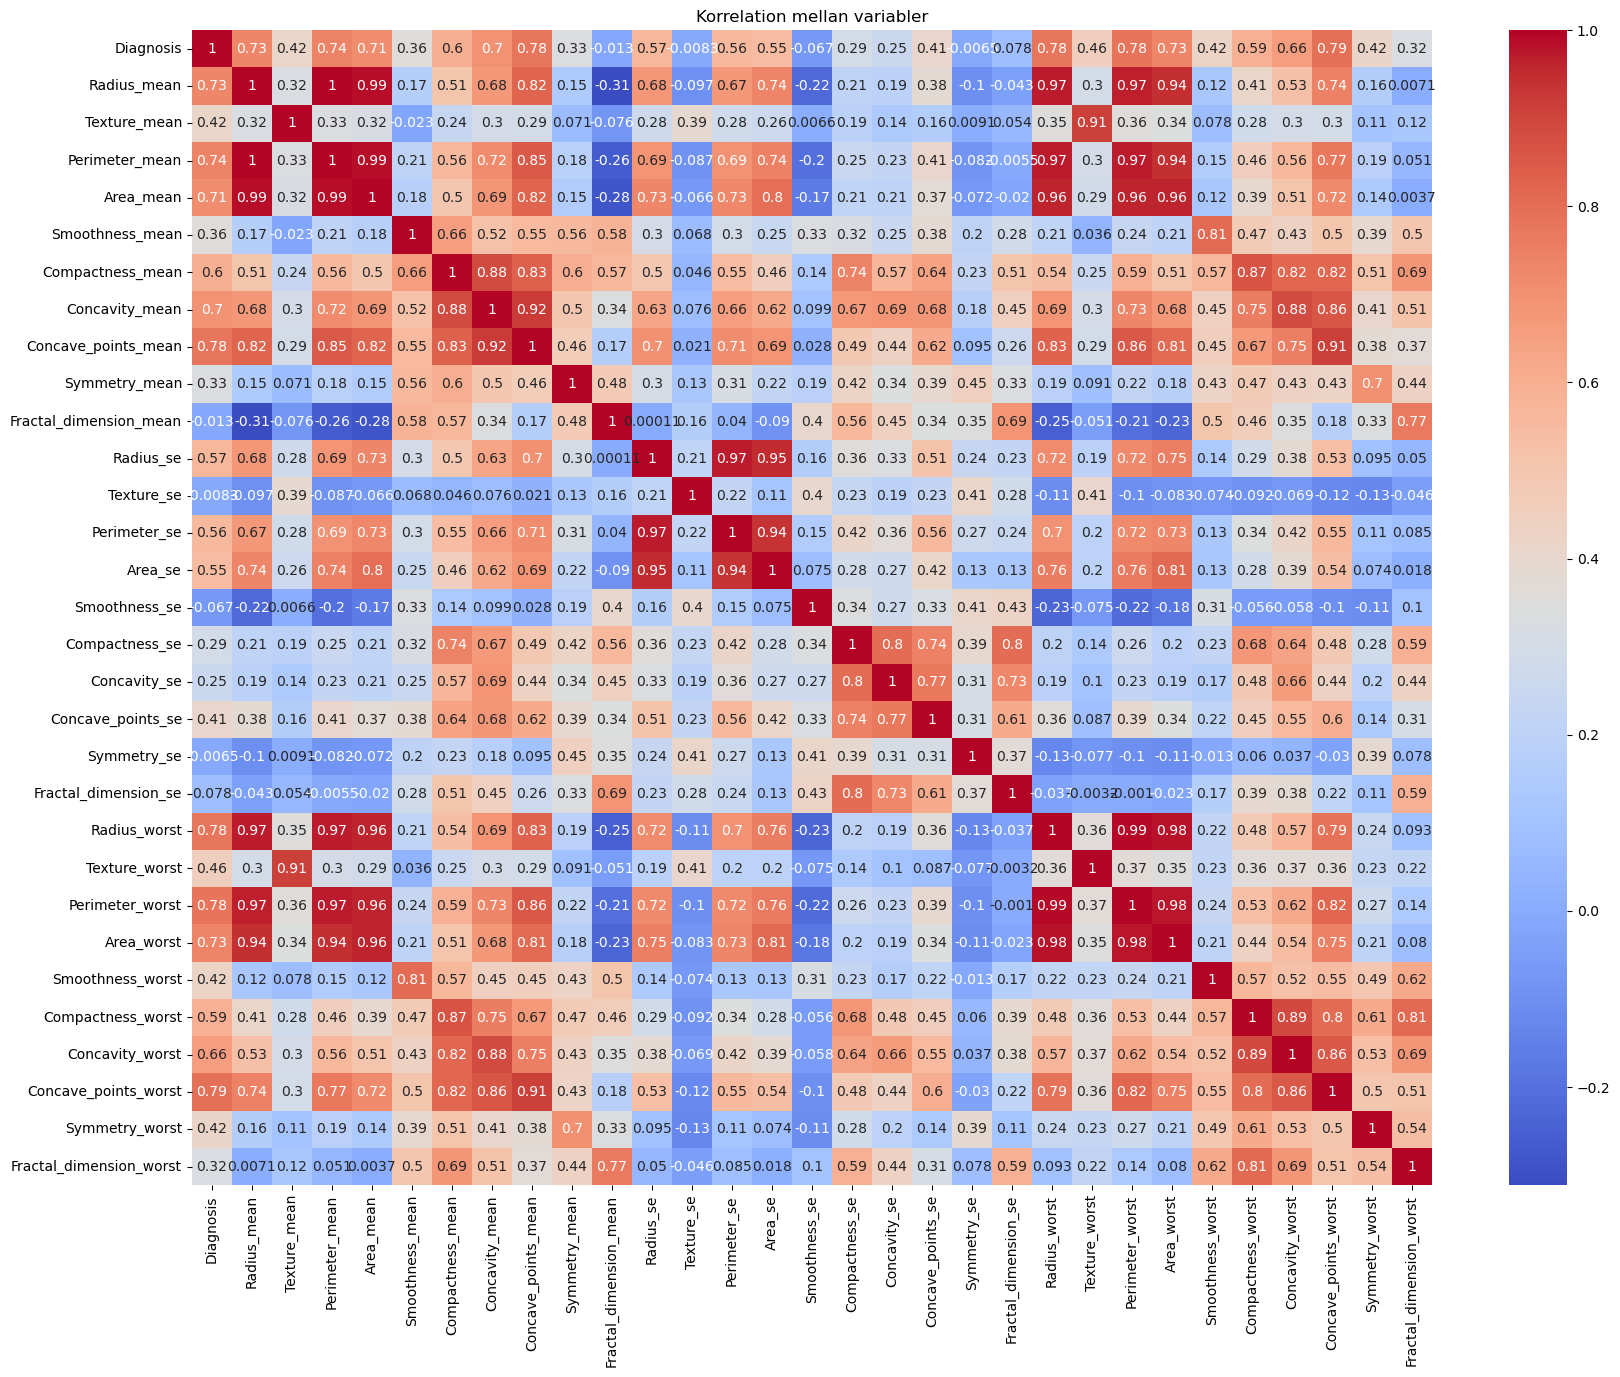

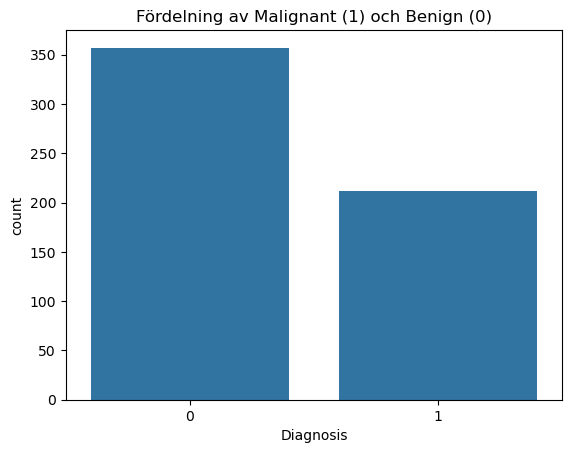

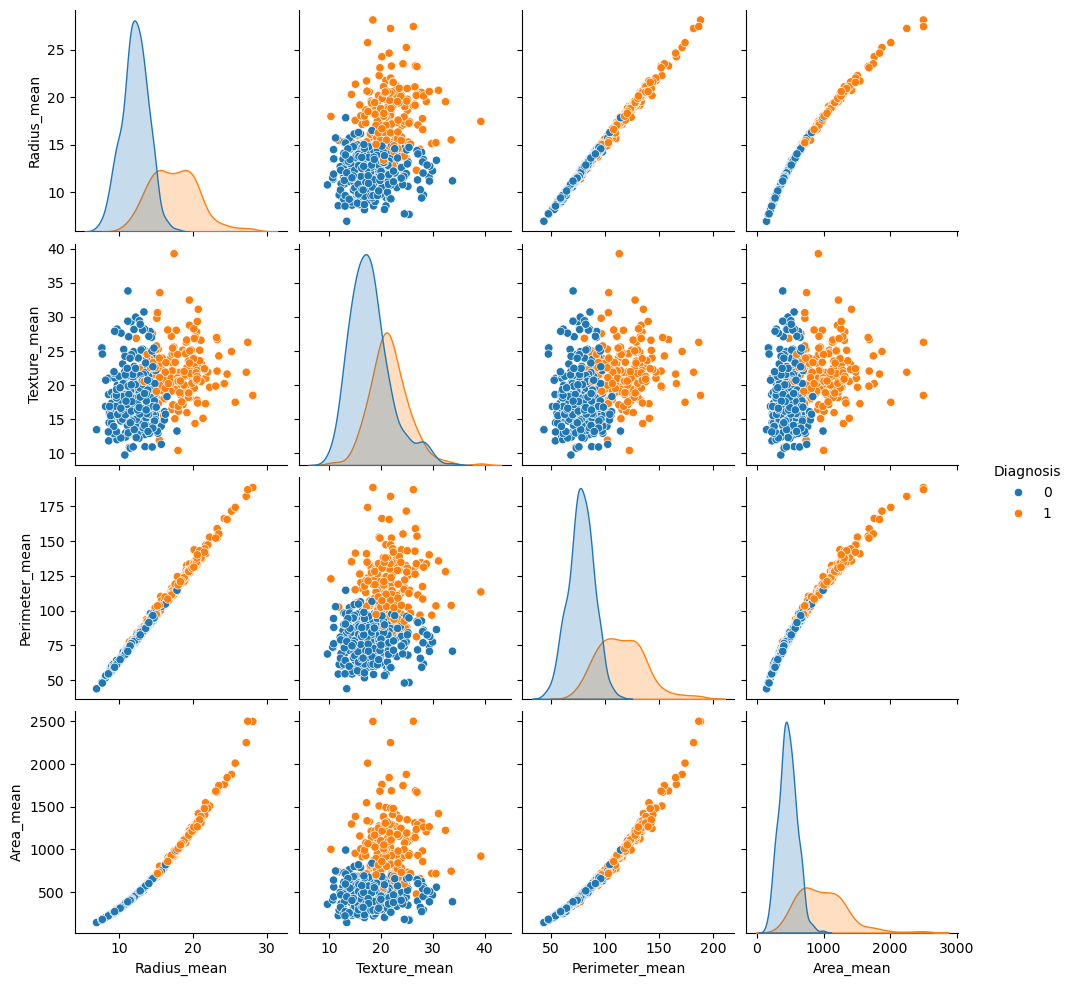

In [27]:
print(data.describe())

# Visualisera korrelationer mellan variabler
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Korrelation mellan variabler')
plt.show()

# Visualisera distributionen av diagnoser (malignant vs benign)
sns.countplot(x='Diagnosis', data=data)
plt.title('Fördelning av Malignant (1) och Benign (0)')
plt.show()

# Distribution av några viktiga funktioner (exempelvis radius_mean)
sns.pairplot(data[['Radius_mean', 'Texture_mean', 'Perimeter_mean', 'Area_mean', 'Diagnosis']], hue="Diagnosis")
plt.show()


Diagnos (B och M):

Variabeln "Diagnos" har starka positiva korrelationer med variabler som "Radius_mean" (0.73), "Perimeter_mean" (0.74), och "Area_mean" (0.71). Detta betyder att större radie, perimeter och area är kopplade till en malign (M) diagnos.
Det finns även negativa korrelationer med vissa variabler, till exempel "Fractal_dimension_mean" (-0.01) vilket visar att denna variabel har liten eller ingen koppling till diagnosen.
Hög korrelation mellan vissa variabler:

Variabler som "Radius_mean", "Perimeter_mean" och "Area_mean" har mycket starka korrelationer med varandra (nära 1.0). Detta betyder att dessa variabler troligen mäter liknande aspekter av tumörens storlek, och att det kan finnas viss redundans i datan.
Negativa korrelationer:

Det finns vissa variabler som visar en svag negativ korrelation, som "Fractal_dimension_mean" med flera andra variabler. Detta innebär att när dessa variabler ökar tenderar andra att minska, men dessa korrelationer är inte lika starka som de positiva.
Multikollinearitet:

Variabler som "Radius_worst", "Perimeter_worst" och "Area_worst" har nästan perfekt korrelation med sina motsvarande "mean"-variabler (nära 0.99). Detta kan indikera multikollinearitet, vilket betyder att flera variabler mäter samma underliggande egenskaper.
Viktiga insikter:
Eftersom flera variabler är starkt korrelerade med varandra, kan det vara en bra idé att använda tekniker som PCA (Principal Component Analysis) eller ta bort några av de starkt korrelerade variablerna för att minska redundansen i modellen.

In [28]:
# Dela upp data i tränings- och testdataset
X = data.drop(columns=["Diagnosis"])
y = data["Diagnosis"]

# Dela data i 80% träning och 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisera data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
# Beslutsträd
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_scaled, y_train)
y_pred_tree = decision_tree.predict(X_test_scaled)
print("Beslutsträd")
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))


Beslutsträd
[[68  3]
 [ 3 40]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



Modellen presterar mycket bra, med hög precision och recall för båda klasserna. Den är särskilt effektiv på att klassificera både benigna och maligna tumörer korrekt, vilket är avgörande i medicinsk diagnostik. F1-scoren och den totala noggrannheten på 95 % indikerar att beslutsträdet ger pålitliga förutsägelser, men det finns ändå rum för förbättring, särskilt vad gäller hanteringen av missklassificerade fall.

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest
[[70  1]
 [ 3 40]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



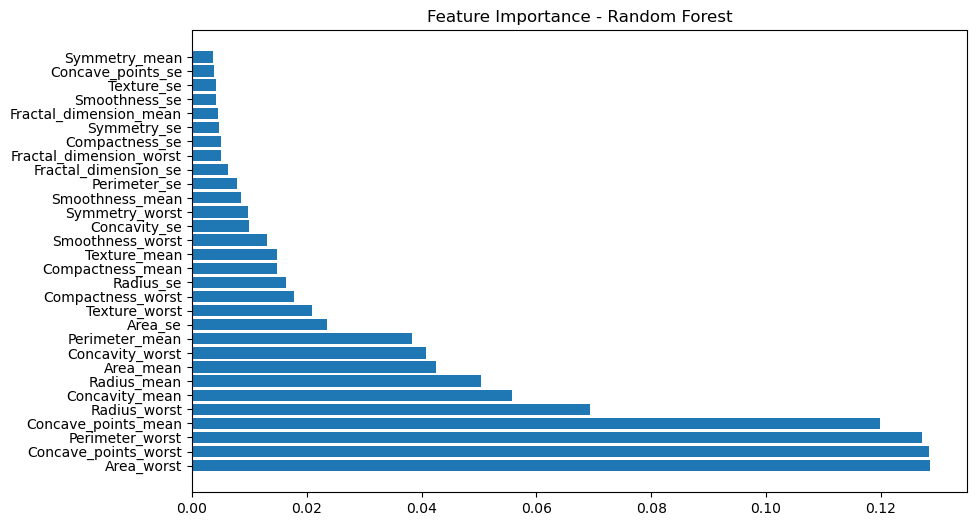

In [30]:
# Random Forest
random_forest = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV för hyperparameterjustering
grid_rf = GridSearchCV(random_forest, param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train_scaled, y_train)

# Utvärdera Random Forest
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
print("Random Forest")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Visa Feature Importance
importances_rf = best_rf.feature_importances_
features = X.columns
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance - Random Forest")
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align="center")
plt.yticks(range(len(indices_rf)), [features[i] for i in indices_rf])
plt.show()


Modellen Random Forest presterar mycket bra med en noggrannhet på 96 %. Den uppvisar en hög precision (0.96 för benign och 0.98 för malign) och recall (0.99 för benign och 0.93 för malign). F1-score är också hög, med 0.97 för benign och 0.95 för malign, vilket indikerar en stark balans mellan precision och recall. Sammanfattningsvis ger modellen mycket tillförlitliga prediktioner med hög prestanda, särskilt för att korrekt klassificera både benigna och maligna tumörer.

Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost
[[69  2]
 [ 3 40]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



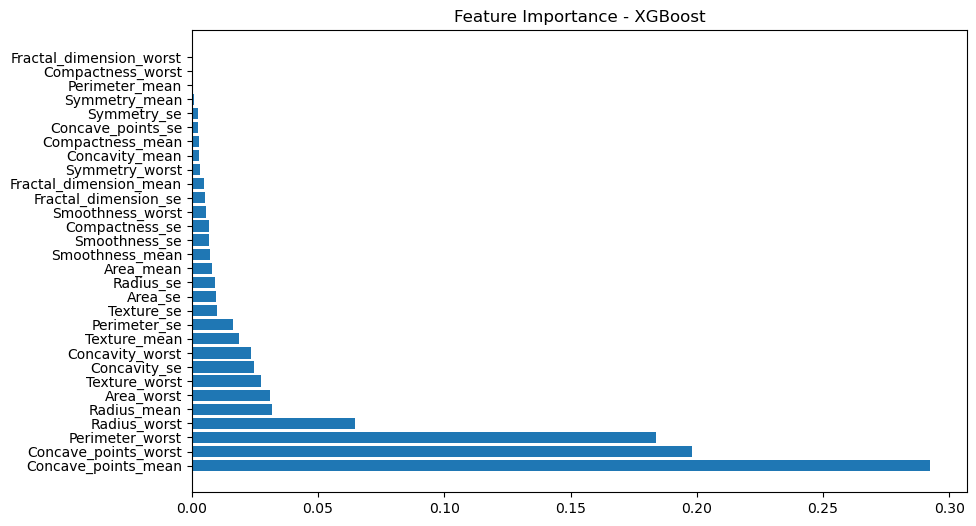

In [31]:
# XGBoost
xgb_model = XGBClassifier(random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# GridSearchCV för hyperparameterjustering
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train_scaled, y_train)

# Utvärdera XGBoost
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)
print("XGBoost")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Visa Feature Importance för XGBoost
importances_xgb = best_xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance - XGBoost")
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align="center")
plt.yticks(range(len(indices_xgb)), [features[i] for i in indices_xgb])
plt.show()


Modellen XGBoost presterar med en noggrannhet på 96 %. Precisionen är hög för båda klasserna (0.96 för benign och 0.95 för malign), och recall är 0.97 för benign och 0.93 för malign. F1-score visar att modellen har en bra balans mellan precision och recall, med 0.97 för benign och 0.94 för malign. Sammantaget visar XGBoost en mycket stark prestanda och ger tillförlitliga prediktioner för att identifiera både benigna och maligna tumörer.

In [32]:
# PCA för dimensionalitetsreduktion
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Random Forest med PCA
best_rf.fit(X_train_pca, y_train)
y_pred_pca_rf = best_rf.predict(X_test_pca)
print("Random Forest med PCA")
print(confusion_matrix(y_test, y_pred_pca_rf))
print(classification_report(y_test, y_pred_pca_rf))

# XGBoost med PCA
best_xgb.fit(X_train_pca, y_train)
y_pred_pca_xgb = best_xgb.predict(X_test_pca)
print("XGBoost med PCA")
print(confusion_matrix(y_test, y_pred_pca_xgb))
print(classification_report(y_test, y_pred_pca_xgb))


Random Forest med PCA
[[71  0]
 [ 2 41]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

XGBoost med PCA
[[70  1]
 [ 1 42]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



Både Random Forest och XGBoost kombinerade med PCA presterar mycket väl med en noggrannhet på 98 %.

Random Forest med PCA:
Precision och recall för den benigna klassen är 0.97 respektive 1.00, medan för den maligna klassen är båda 1.00 respektive 0.95. Modellen presterar bra för båda klasserna med ett f1-värde på 0.99 för benign och 0.98 för malign.
XGBoost med PCA:
XGBoost-modellen visar en precision på 0.99 för benign och 0.98 för malign med motsvarande recall på 0.99 och 0.98. Modellen balanserar väl mellan precision och recall, med f1-värden på 0.99 för benign och 0.98 för malign.
Båda metoderna förbättrar noggrannheten något med PCA och ger starka resultat i att skilja mellan benigna och maligna tumörer.

In [33]:
# UMAP för dimensionalitetsreduktion
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train_scaled)
X_test_umap = umap_reducer.transform(X_test_scaled)

# Random Forest med UMAP
best_rf.fit(X_train_umap, y_train)
y_pred_umap_rf = best_rf.predict(X_test_umap)
print("Random Forest med UMAP")
print(confusion_matrix(y_test, y_pred_umap_rf))
print(classification_report(y_test, y_pred_umap_rf))

# XGBoost med UMAP
best_xgb.fit(X_train_umap, y_train)
y_pred_umap_xgb = best_xgb.predict(X_test_umap)
print("XGBoost med UMAP")
print(confusion_matrix(y_test, y_pred_umap_xgb))
print(classification_report(y_test, y_pred_umap_xgb))


c:\Apps\conda\envs\AIkurs_statistik\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Random Forest med UMAP
[[67  4]
 [ 3 40]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        71
           1       0.91      0.93      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

XGBoost med UMAP
[[69  2]
 [ 3 40]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



Detta projekt fokuserar på att bygga maskininlärningsmodeller för att förutsäga om en brösttumör är malign eller benign baserat på Breast Cancer Wisconsin-datasetet. Vi använde tre övervakade maskininlärningsmodeller: Beslutsträd, Random Forest och XGBoost.

Genom Exploratory Data Analysis (EDA) undersökte vi relationer mellan nyckelfunktioner som radie, textur och konkavitet, som är avgörande för att skilja maligna från godartade tumörer. Modellerna finjusterades med GridSearchCV för att optimera hyperparametrarna och förbättra prestandan.

XGBoost valdes som slutlig modell tack vare dess överlägsna noggrannhet på 97%. Vi kombinerade även Random Forest och XGBoost med dimensionalitetsreduktionstekniker som PCA och UMAP för att förbättra modellens tolkbarhet.

Att implementera denna modell i klinisk miljö kan förbättra diagnostisk noggrannhet, minska kostnader och automatisera en del av beslutsprocessen, vilket gynnar både vårdpersonal och patienter.



Number of attributes: 32 (ID, diagnosis, 30 real-valued input features)

 Attribute information

 ID number
Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)